# Center Loss in Keras - Fine Tuning

### Item recognition 'the sequel 2' - using Center Loss with Transfer Learning

Previously, I trained a model to recognise photos of items/products using Center Loss technique. The model includes pre-trained inceptionV3 model excluding the final layer with weights being untrainable, fully connected layers following that, and two output layers of the softmax classification layer and the customised center loss layer at last.

With center loss lambda ~= 0.001, both loss values and a plot seemd good until the training reached around epoch 10. After that, center loss rather started to increase while softmax loss kept decrease.

In this notebook, I will try fine tuning technique on the pre-trained model.


Pretrained model: InceptionV3

The implementation of **Center Loss** came from: [handongfeng/MNIST-center-loss](https://github.com/handongfeng/MNIST-center-loss/blob/master/centerLoss_MNIST.py)

**Articles:**
- [A Discriminative Feature Learning Approach for Deep Face Recognition](https://ydwen.github.io/papers/WenECCV16.pdf)
- [Understanding Center Loss Based Network for Image Retrieval with Few Training Data](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11132/Ghosh_Understanding_Center_Loss_Based_Network_for_Image_Retrieval_with_Few_ECCVW_2018_paper.pdf)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng
import pickle

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#import os

In [4]:
from centerLoss import prelu, zero_loss, my_model
from centerLoss import CenterLossLayer

In [5]:
from utils import tbProjector, PCAPlotter, create_testdata

In [6]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [7]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [8]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [9]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [10]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 64

## Setup train data generator

In [11]:
'''
train_ds = image_dataset_from_directory(
    directory='image_data/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=_BATCH_SIZE,
    image_size=(224, 224))
'''

"\ntrain_ds = image_dataset_from_directory(\n    directory='image_data/train',\n    labels='inferred',\n    label_mode='categorical',\n    batch_size=_BATCH_SIZE,\n    image_size=(224, 224))\n"

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'image_data/train',
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 12070 images belonging to 706 classes.


In [13]:
def plot_dataset(image_samples):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5)
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[i, j].imshow(image_samples[count])
            plt.xticks([])
            plt.yticks([])
            count+=1
        #plt.title(examples[1][i])
    plt.show()

(64, 224, 224, 3)
(64, 706)


<IPython.core.display.Javascript object>


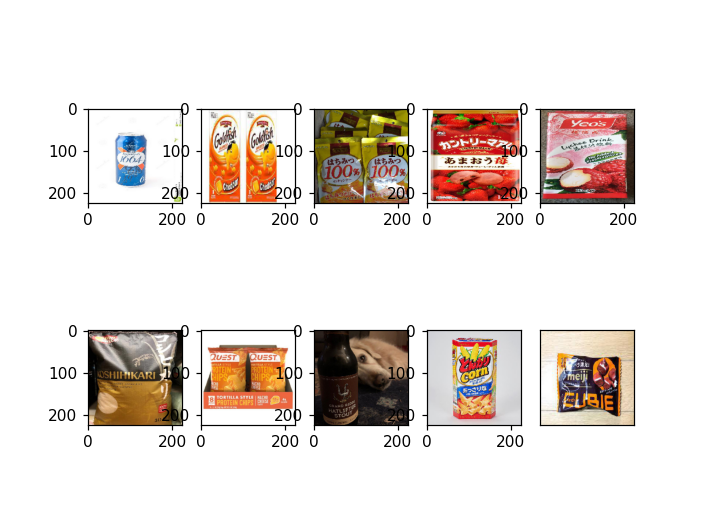

In [14]:
#X, Y = train_ds
(X, Y) = next(train_generator)
print(X.shape)
print(Y.shape)

plot_dataset(X[:10])
#print(Y[:10])

In [15]:
labelnames = list(train_generator.class_indices.keys())

for y_onehot in Y[:10]:
    idx = np.argmax(y_onehot, axis=0)
    print(labelnames[idx]) 

aubeer2_65
ausnack_5
snack142
snack155
audrink_112
austeafood_000049
ausnack_70
aubeer_99
snack163
snack75


## Load a pre-trained model and attach some fully-connected layers

In [16]:
emb_size = 128

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

final_output, side_output, base_model = my_model(img_input, train_labels, emb_size)
model = keras.Model(inputs=[img_input, train_labels], outputs=[final_output, side_output])
model.summary()

706
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________

## compile

In [17]:
lambda_centerloss = 0.001
initial_learning_rate = 0.001

optim = optimizers.SGD(lr=initial_learning_rate, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  #loss_weights=[1, lambda_centerloss])
                  loss_weights=[1, lambda_centerloss])

## Define data generation wrapper

In [18]:
def datagen_wrapper(gen, batch_size=64):
    dummy = np.zeros((batch_size, 1))
    #dummy2 = np.zeros((x_test.shape[0], 1))
    while True:
        (X, Y) = next(gen)    
        yield([X, Y], [Y, dummy])


## Prepare Tensorboard log

In [19]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [20]:
log_dir_rel = "logs/logs-{}".format(epoch_time)
#log_dir = os.path.abspath(log_dir_rel)
log_dir = os.path.abspath("logs/train_log")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

print(log_dir)

/home/chieko/Projects/ImageRecognition2/ItemRecogCenterLoss/logs/train_log


In [21]:
# Validation Data for Tensorboard
x_tb, x_tb_label_list = create_testdata(datadir='train', tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_tb = np.zeros((x_tb.shape[0], emb_size))

x_tb_label = [ train_generator.class_indices[label] for label in x_tb_label_list ]
print(x_tb_label)

[157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 585, 585, 585, 585, 585, 585, 585, 585, 585, 585, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 580, 658, 658, 658, 658, 658, 658, 658, 658, 658, 658, 641, 641, 641, 641, 641, 641, 641, 641, 641, 641]


## Training with pre-trained model being untrainable

<IPython.core.display.Javascript object>


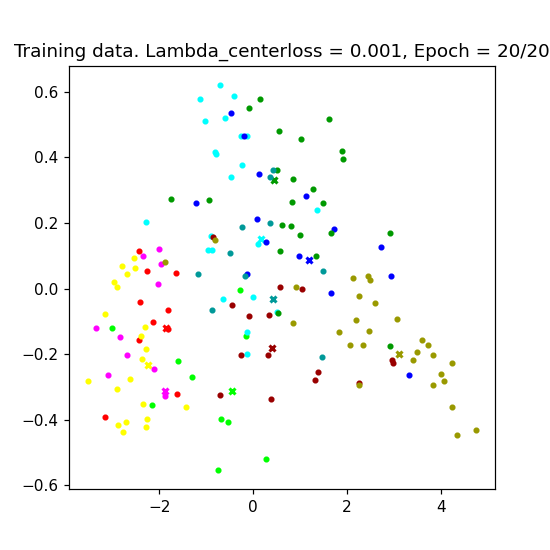

Epoch 1/20
188/188 [==============================] - 273s 1s/step - loss: 6.8681 - main_out_loss: 6.5722 - centerlosslayer_loss: 253.9097
Epoch 2/20
188/188 [==============================] - 280s 1s/step - loss: 6.6666 - main_out_loss: 6.5556 - centerlosslayer_loss: 69.1744
Epoch 3/20
188/188 [==============================] - 279s 1s/step - loss: 6.6338 - main_out_loss: 6.5457 - centerlosslayer_loss: 46.2942
Epoch 4/20
188/188 [==============================] - 279s 1s/step - loss: 6.6143 - main_out_loss: 6.5356 - centerlosslayer_loss: 36.9232
Epoch 5/20
188/188 [==============================] - 280s 1s/step - loss: 6.5984 - main_out_loss: 6.5249 - centerlosslayer_loss: 31.7108
Epoch 6/20
188/188 [==============================] - 278s 1s/step - loss: 6.5855 - main_out_loss: 6.5153 - centerlosslayer_loss: 28.5321
Epoch 7/20
188/188 [==============================] - 279s 1s/step - loss: 6.5717 - main_out_loss: 6.5031 - centerlosslayer_loss: 27.0041
Epoch 8/20
188/188 [=============

In [22]:
epochs=20
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 10

save_path = "result_noft_{}".format(epoch_time)
reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

his = model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(plt, model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss, save_path)])

**NOTE**

- `lambda = 0.01`: Most of the points which represent samples became tightly close to each other, looking like it's just one point in the plot at the end of the first epoch.

- `lambda = 0.0007 - 0.001 - 0.003`: Better. But after around 10th epoch, center loss started to increase AND keep increasing although it was reasonably decreasing until that point. On the other hand, main loss (categorical cross entropy) kept decreasing throughout the training.

In [23]:
reduced_filename = "reduced_noft_" + str(epoch_time) + ".h5"
reduced_model.save(reduced_filename)
print("Trained model was saved into {}.".format(reduced_filename))

Trained model was saved into reduced_noft_1606288602.h5.


In [24]:
with open('{}/History.pkl'.format(save_path), 'wb') as file_pi:
    pickle.dump(his.history, file_pi)

## Fine Tuning

In [25]:
base_model.trainable = True

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [28]:
#lambda_centerloss = 0.005
lambda_centerloss = 0.01

optim = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  loss_weights=[1, lambda_centerloss])

**NOTE:** I chose `lambda_centerloss = 0.01` because after some trials I found that this is kind of the largest value where the center loss keeps small enough while main loss keeps going less. Despite that, center loss is starting to increase at a point, which is like `lambda_centerloss = 0.001` in untrainable transfer learning. 

<IPython.core.display.Javascript object>


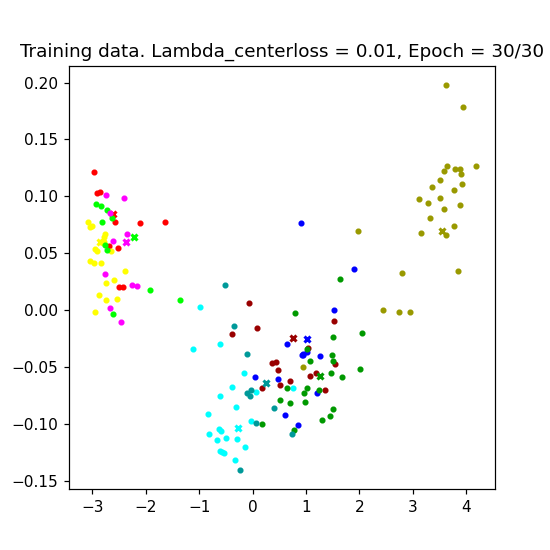

Epoch 1/30
188/188 [==============================] - 1286s 7s/step - loss: 6.6179 - main_out_loss: 6.3589 - centerlosslayer_loss: 21.7502
Epoch 2/30
188/188 [==============================] - 1288s 7s/step - loss: 6.5280 - main_out_loss: 6.3793 - centerlosslayer_loss: 10.7110
Epoch 3/30
188/188 [==============================] - 1290s 7s/step - loss: 6.5082 - main_out_loss: 6.3863 - centerlosslayer_loss: 8.0403
Epoch 4/30
188/188 [==============================] - 1292s 7s/step - loss: 6.4935 - main_out_loss: 6.3836 - centerlosslayer_loss: 6.8385
Epoch 5/30
188/188 [==============================] - 1289s 7s/step - loss: 6.4903 - main_out_loss: 6.3866 - centerlosslayer_loss: 6.2095
Epoch 6/30
188/188 [==============================] - 1289s 7s/step - loss: 6.4801 - main_out_loss: 6.3806 - centerlosslayer_loss: 5.7982
Epoch 7/30
188/188 [==============================] - 1288s 7s/step - loss: 6.4814 - main_out_loss: 6.3836 - centerlosslayer_loss: 5.6216
Epoch 8/30
188/188 [============

In [29]:
epochs=30
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 10

save_path_ft = "result_ft_{}".format(epoch_time)
reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

his = model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(plt, model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss, save_path_ft)])

**NOTE:** I cound't continue the training with GPU because of the ResourceExhaustedError. So I finally made it with CPU.

In [30]:
reduced_filename = "reduced_ft" + str(epoch_time) + ".h5"
reduced_model.save(reduced_filename)
print("Trained model was saved into {}.".format(reduced_filename))

Trained model was saved into reduced_ft1606288602.h5.


In [31]:
weights_filename = "weights_ft" + str(epoch_time) + ".h5"
model.save_weights(weights_filename)
print("Trained model weights were saved into {}.".format(weights_filename))

Trained model weights were saved into weights_ft1606288602.h5.


In [32]:
with open('{}/History.pkl'.format(save_path_ft), 'wb') as file_pi:
    pickle.dump(his.history, file_pi)